# Bitcoin Price Prediction Model - Shreya Vontela 


## Disclaimer : 
### I have used plotly for my graphs. To view the graphs without running the notebook, please make the notebook "Trusted". If it is untrusted , then you cant see the graphs directly when you open the notebook. You can find a trusted button on top right corner of the jupyter notebook. 









In [1]:
#Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import yfinance as yf
import plotly.graph_objects as go
import datetime
from sklearn.metrics import mean_absolute_error
import sklearn
import math
from sklearn import preprocessing

# To avoid warnings 
import pandas as pd
pd.options.mode.chained_assignment = None  

# Model imports 
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model
from keras import backend


### Useful definitions 

In [2]:
# Creating a dataframe to store values later on 
evaluation = pd.DataFrame(columns = ["Test_MAE","Test_RMSE","Train_MAE","Validation_MAE"], 
                          index = ["Simple NN model","RNN model with LSTM layer","RNN model with GRU layer",
                                   "RNN model with GRU layer and Reccurent Dropout",
                                   "RNN model with GRU layer and Double Dropout "])

# Setting the dates and tickers for feature selection 
start_date = '2010-01-01'
end_date = '2020-09-10'
nasdaq_ticker = '^IXIC'
gold_ticker = 'GC=F'

In [1]:
# Function to plot bitcoing price graph
def plot_graph(title,xlabel,ylabel,df,col):
    data = []
    for i in range(len(col)): 
        plot = go.Scatter(x=df.index,y=df[col[i]], name=col[i])
        data.append(plot)


    layout = go.Layout(title= title ,
                    xaxis=dict(title=xlabel),
                    yaxis=dict(title=ylabel ), 
                    width = 690, 
                    height = 550, 
                    autosize = False)

    fig = go.Figure(data=data, layout=layout)
    
    fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1 ))

    fig.show()
    
# Function to plot the validation loss 
def plot_training_validation_loss(df):
    title = "Training and Validation Loss"
    xlabel = 'Epochs'
    ylabel = 'Loss'

    plot1 = go.Scatter(x = df.epoch, y=df.history['loss'], name='Training Loss', marker=dict(color='red'))
    plot2 = go.Scatter(x = df.epoch, y=df.history['val_loss'], name='Validation Loss', marker=dict(color='blue'))
    data = [plot1,plot2]

    layout = go.Layout(title= title ,
                    xaxis=dict(title=xlabel),
                    yaxis=dict(title=ylabel ), 
                    width = 690, 
                    height = 550, 
                    autosize = False)
    
    

    fig = go.Figure(data=data, layout=layout, xaxis =  {'showgrid': False},yaxis = {'showgrid': True })
    
    fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1 ))

    fig.show()
    
    
# Function to calculate the MAE Loss and RMSE
def eval_model(model_name,df,best_model):
    saved_model = load_model(best_model)
    df.loc[model_name,"Train_MAE"], _ = saved_model.evaluate(X_train, Y_train, verbose=0)
    df.loc[model_name,"Validation_MAE"], _ = saved_model.evaluate(X_valid, Y_valid, verbose=0)
    df.loc[model_name,"Test_MAE"], _ = saved_model.evaluate(X_test, Y_test, verbose=0)
    Y_predict = saved_model.predict(X_test)
    df.loc[model_name,"Test_RMSE"] = math.sqrt(sklearn.metrics.mean_squared_error(Y_test, Y_predict))
    
    title = model_name + ": Predicted vs Actual Test Data "
    xlabel = 'Index'
    ylabel = 'Values'

    plot1 = go.Scatter(y=Y_predict[:,0], name='Predicted Value', marker=dict(color='red'))
    plot2 = go.Scatter(y=Y_test[:,0], name='Actual Value', marker=dict(color='blue'))
    data = [plot1,plot2]

    layout = go.Layout(title= title ,
                    xaxis=dict(title=xlabel),
                    yaxis=dict(title=ylabel ), 
                    width = 690, 
                    height = 550, 
                    autosize = False)

    fig = go.Figure(data=data, layout=layout)
    
    fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1 ))

    fig.show()


# Part 1: Data Gathering and Analysis

### Data downloading and processing  

In [4]:
nasdaq = yf.download(nasdaq_ticker, 
                      start=start_date, 
                      end=end_date, 
                      progress=False)

nasdaq = nasdaq.rename(columns = {"Close":  "Nasdaq_price"})

In [5]:
gold = yf.download(gold_ticker, 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
gold = gold.rename(columns = {"Close":  "Gold_price"})

In [6]:
bitcoin = pd.read_csv("BitcoinData.csv")
bitcoin.Date = pd.to_datetime(bitcoin.Date)
bitcoin = bitcoin.set_index(bitcoin.Date)
bitcoin = bitcoin.drop(columns = "Date")

### Including the weekends dates and Interpolating the price 

In [7]:
all_days = pd.date_range(start=start_date, end=end_date)
nasdaq = nasdaq.reindex(all_days).interpolate(method = "linear")
gold = gold.reindex(all_days).interpolate(method = "linear")

### Merging all the dataframes 

In [8]:
bitcoin = bitcoin.merge(gold[["Gold_price"]], left_index=True, right_index=True)
bitcoin = bitcoin.merge(nasdaq[["Nasdaq_price"]], left_index=True, right_index=True)
bitcoin.head(6)

Bitcoin Core (BTC) Price  Chain Value Density  Daily Transactions  \
Date                                                                            
2010-01-01                       0.0                  0.0                 138   
2010-01-02                       0.0                  0.0                 134   
2010-01-03                       0.0                  0.0                 126   
2010-01-04                       0.0                  0.0                 186   
2010-01-05                       0.0                  0.0                 183   
2010-01-06                       0.0                  0.0                 198   

            Difficulty  Fee Percentage  Fee Rate  Hash Rate  \
Date                                                          
2010-01-01         1.0             0.0         0   0.000008   
2010-01-02         1.0             0.0         0   0.000008   
2010-01-03         1.0             0.0         0   0.000007   
2010-01-04         1.0             0.0         0   0.000007   
2010-01-05         1.0             0.0         0   0.000008   
2010-01-06         1.0             0.0         0   0.000008   

            Two-Week Hash Growth  Inflation Rate  Metcalfe's Law - UTXO  \
Date                                                                      
2010-01-01              26.26030         56.3042                    0.0   
2010-01-02               9.73085         56.2034                    0.0   
2010-01-03              -3.98482         56.1022                    0.0   
2010-01-04              -7.53363         56.0296                    0.0   
2010-01-05              -9.51178         55.9413                    0.0   
2010-01-06             -11.12900         55.8413                    0.0   

            Miner Revenue  Money Supply  Price Volatility  Total Transactions  \
Date                                                                            
2010-01-01         6900.0     1624700.0        149.632178               32713   
2010-01-02         6600.0     1631300.0        149.476140               32847   
2010-01-03         6300.0     1637600.0        173.587189               32973   
2010-01-04         9300.0     1646900.0        173.392077               33159   
2010-01-05         9050.0     1655950.0        173.995732               33342   
2010-01-06         9900.0     1665850.0        173.987032               33540   

            Transaction Fees  Transaction Value  Velocity of Money  \
Date                                                                 
2010-01-01               0.0                0.0           0.217045   
2010-01-02               0.0                0.0           0.216228   
2010-01-03               0.0                0.0           0.215396   
2010-01-04               0.0                0.0           0.214180   
2010-01-05               0.0                0.0           0.225573   
2010-01-06               0.0                0.0           0.224232   

             Gold_price  Nasdaq_price  
Date                                   
2010-01-01          NaN           NaN  
2010-01-02          NaN           NaN  
2010-01-03          NaN           NaN  
2010-01-04  1117.699951   2308.419922  
2010-01-05  1118.099976   2308.709961  
2010-01-06  1135.900024   2301.090088

## Plot a time series of BTC prices



In [9]:
title = "BTC Prices"
xlabel = 'Date'
ylabel = 'Closing Price'
df = bitcoin
col = ["Bitcoin Core (BTC) Price"]

plot_graph(title,xlabel,ylabel,df,col)

## Normalize each of the data fields

In [10]:
#Normalizing using MinMaxScaler 
x = bitcoin.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
bitcoin=pd.DataFrame(x_scaled, columns=bitcoin.columns , index = bitcoin.index)
bitcoin

Bitcoin Core (BTC) Price  Chain Value Density  Daily Transactions  \
Date                                                                            
2010-01-01                  0.000000             0.000000            0.000052   
2010-01-02                  0.000000             0.000000            0.000044   
2010-01-03                  0.000000             0.000000            0.000028   
2010-01-04                  0.000000             0.000000            0.000149   
2010-01-05                  0.000000             0.000000            0.000143   
...                              ...                  ...                 ...   
2020-09-06                  0.528920             0.288819            0.651572   
2020-09-07                  0.534778             0.291823            0.519860   
2020-09-08                  0.540523             0.294756            0.658517   
2020-09-09                  0.527428             0.287443            0.661877   
2020-09-10                  0.533369             0.290522            0.646263   

            Difficulty  Fee Percentage  Fee Rate     Hash Rate  \
Date                                                             
2010-01-01    0.000000        0.000000  0.000000  7.123531e-15   
2010-01-02    0.000000        0.000000  0.000000  6.194375e-15   
2010-01-03    0.000000        0.000000  0.000000  3.561766e-15   
2010-01-04    0.000000        0.000000  0.000000  4.568352e-15   
2010-01-05    0.000000        0.000000  0.000000  6.968672e-15   
...                ...             ...       ...           ...   
2020-09-06    1.000000        0.059313  0.007784  9.461425e-01   
2020-09-07    1.000000        0.035575  0.003774  9.683479e-01   
2020-09-08    0.982955        0.039268  0.005189  9.904442e-01   
2020-09-09    0.982955        0.036697  0.004953  9.896028e-01   
2020-09-10    0.982955        0.033765  0.006133  9.926932e-01   

            Two-Week Hash Growth  Inflation Rate  Metcalfe's Law - UTXO  \
Date                                                                      
2010-01-01              0.048225        1.000000               0.000000   
2010-01-02              0.032824        0.998106               0.000000   
2010-01-03              0.020045        0.996204               0.000000   
2010-01-04              0.016739        0.994840               0.000000   
2010-01-05              0.014896        0.993180               0.000000   
...                          ...             ...                    ...   
2020-09-06              0.025945             NaN               0.286786   
2020-09-07              0.027694             NaN               0.290665   
2020-09-08              0.027068             NaN               0.294285   
2020-09-09              0.027685             NaN               0.287044   
2020-09-10              0.027125             NaN               0.289889   

            Miner Revenue  Money Supply  Price Volatility  Total Transactions  \
Date                                                                            
2010-01-01       0.182004      0.000000          0.545773        0.000000e+00   
2010-01-02       0.173145      0.000391          0.545158        2.357870e-07   
2010-01-03       0.164286      0.000765          0.640226        4.574971e-07   
2010-01-04       0.252878      0.001317          0.639457        7.847835e-07   
2010-01-05       0.245495      0.001854          0.641837        1.106791e-06   
...                   ...           ...               ...                 ...   
2020-09-06       0.007751      0.999767               NaN        9.978194e-01   
2020-09-07       0.007951      0.999822               NaN        9.982753e-01   
2020-09-08       0.013429      0.999887               NaN        9.988528e-01   
2020-09-09       0.009272      0.999945               NaN        9.994332e-01   
2020-09-10       0.008491      1.000000               NaN        1.000000e+00   

            Transaction Fees  Transaction Value  Velocity of Money  \

## Calculate a correlation matrix and identify any correlation in the features

In [11]:
bitcoin.corr()

Bitcoin Core (BTC) Price  Chain Value Density  \
Bitcoin Core (BTC) Price                  1.000000             0.888201   
Chain Value Density                       0.888201             1.000000   
Daily Transactions                        0.736568             0.607964   
Difficulty                                0.788682             0.531297   
Fee Percentage                            0.420738             0.478721   
Fee Rate                                 -0.091355            -0.042515   
Hash Rate                                 0.795687             0.538985   
Two-Week Hash Growth                     -0.125166            -0.090244   
Inflation Rate                           -0.324382            -0.375022   
Metcalfe's Law - UTXO                     0.858608             0.985718   
Miner Revenue                            -0.558363            -0.518634   
Money Supply                              0.639768             0.593426   
Price Volatility                         -0.073733            -0.185505   
Total Transactions                        0.877526             0.675705   
Transaction Fees                          0.398969             0.480871   
Transaction Value                         0.657199             0.661903   
Velocity of Money                        -0.031122             0.030505   
Gold_price                                0.172948             0.018051   
Nasdaq_price                              0.854689             0.707250   

                          Daily Transactions  Difficulty  Fee Percentage  \
Bitcoin Core (BTC) Price            0.736568    0.788682        0.420738   
Chain Value Density                 0.607964    0.531297        0.478721   
Daily Transactions                  1.000000    0.646506        0.404879   
Difficulty                          0.646506    1.000000        0.121894   
Fee Percentage                      0.404879    0.121894        1.000000   
Fee Rate                           -0.158280   -0.146321        0.382778   
Hash Rate                           0.651144    0.997332        0.120295   
Two-Week Hash Growth               -0.206898   -0.125029       -0.058717   
Inflation Rate                     -0.658430   -0.292046       -0.282063   
Metcalfe's Law - UTXO               0.570827    0.498539        0.421756   
Miner Revenue                      -0.773222   -0.485723       -0.309620   
Money Supply                        0.872165    0.562350        0.324026   
Price Volatility                   -0.062341   -0.076458       -0.086403   
Total Transactions                  0.883769    0.898371        0.297105   
Transaction Fees                    0.479416    0.025949        0.836516   
Transaction Value                   0.482376    0.374760        0.314613   
Velocity of Money                   0.163873   -0.174473        0.234017   
Gold_price                         -0.103794    0.369010       -0.007335   
Nasdaq_price                        0.890119    0.829763        0.319255   

                          Fee Rate  Hash Rate  Two-Week Hash Growth  \
Bitcoin Core (BTC) Price -0.091355   0.795687             -0.125166   
Chain Value Density      -0.042515   0.538985             -0.090244   
Daily Transactions       -0.158280   0.651144             -0.206898   
Difficulty               -0.146321   0.997332             -0.125029   
Fee Percentage            0.382778   0.120295             -0.058717   
Fee Rate                  1.000000  -0.147067              0.065268   
Hash Rate                -0.147067   1.000000             -0.120910   
Two-Week Hash Growth      0.065268  -0.120910              1.000000   
Inflation Rate            0.053730  -0.292087              0.292831   
Metcalfe's Law - UTXO    -0.042677   0.506100             -0.079099   
Miner Revenue             0.201326  -0.486144              0.352825   
Money Supply             -0.190234   0.564344             -0.289222   
Price Volatility         -0.036969  -0.071859             -0.017519   
Total Tran

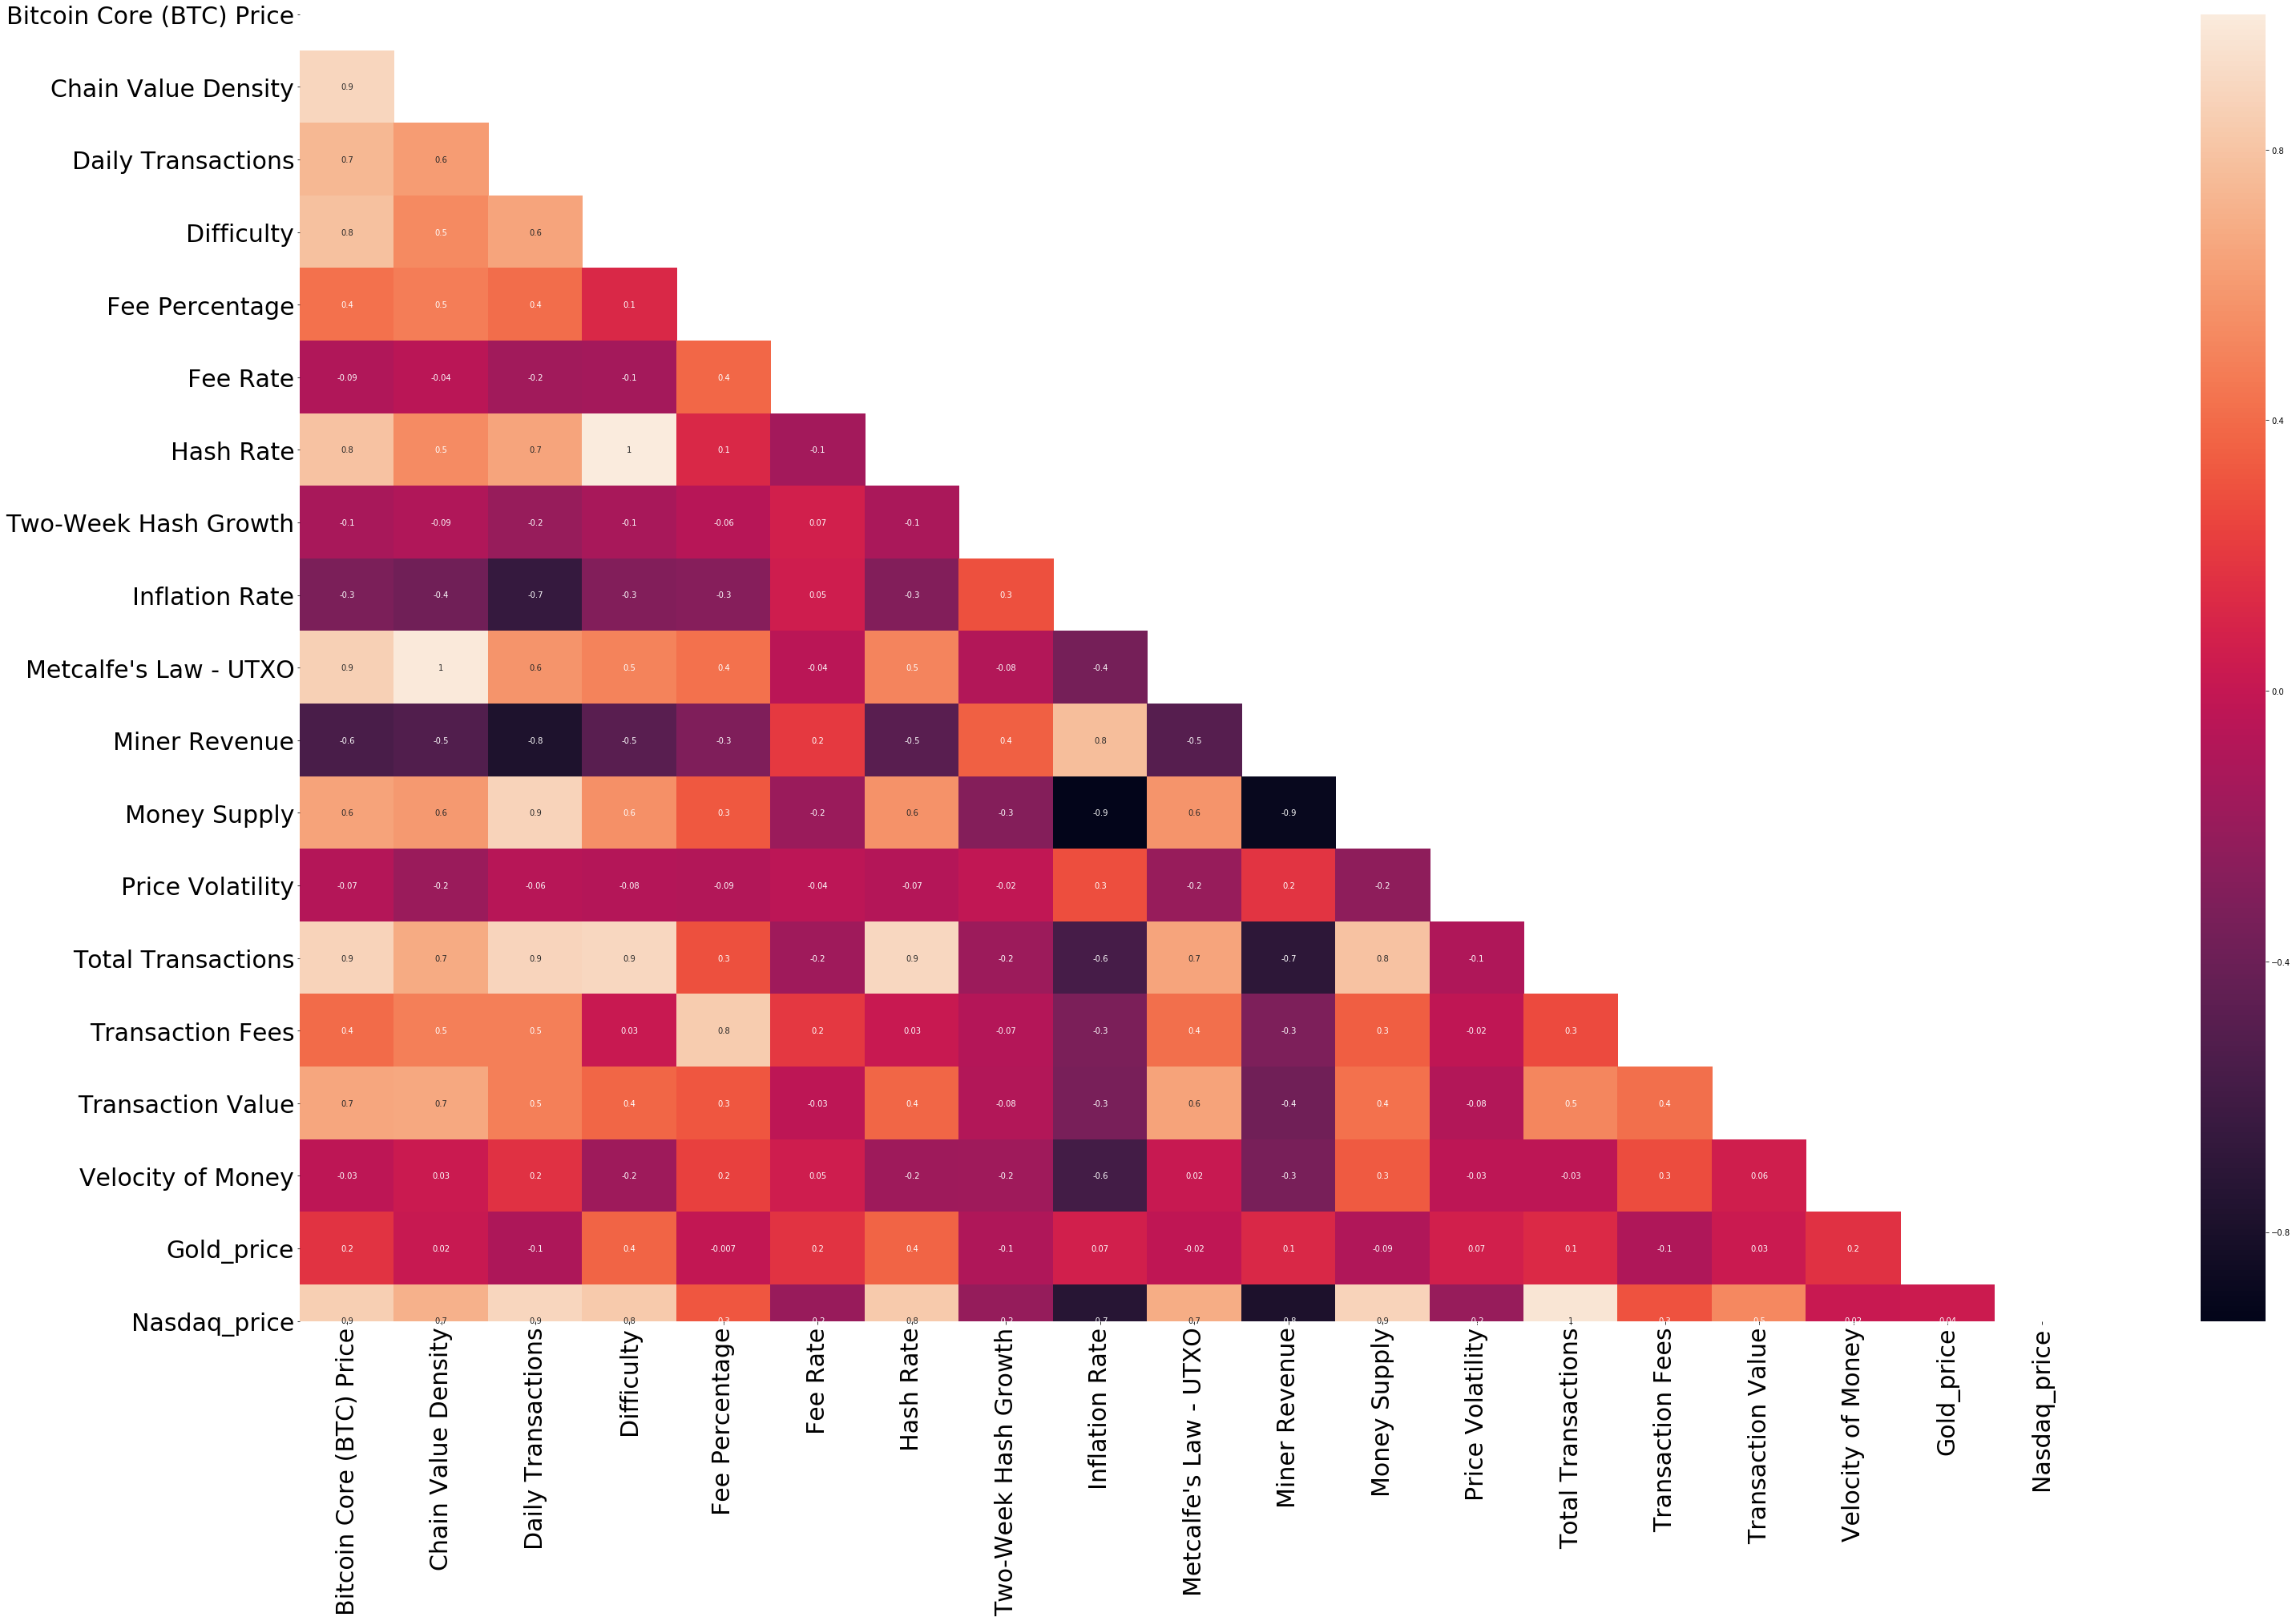

In [12]:
import seaborn as sns
plt.figure(figsize=(50,30))
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
matrix = np.triu(bitcoin.corr())
sns.heatmap(bitcoin.corr(),annot = True,fmt='.1g', mask=matrix)

## Write a brief analysis based on your observations above

From the above data we see that the bitcoin price is highly correlated with 
- Nasdaq Price
- The total number of transactions of bitcoins in a day 
- Hash rate
- Difficulty 
- Chain Value Density

We proceed with all of the variables as inputs as we want to see what the model does with the given data even when there is little correlation.

# Part 2: Data Pre-processing for Models



### Splitting the data as training , validation and test datasets 

In [13]:
training = bitcoin[bitcoin.index.date  <= datetime.date(2019,6,30)]
validation = bitcoin[np.logical_and(bitcoin.index.date >= datetime.date(2019,7,1), 
                                    bitcoin.index.date <= datetime.date(2019,12,31))]
test = bitcoin[np.logical_and(bitcoin.index.date >= datetime.date(2020,1,1), 
                              bitcoin.index.date <= datetime.date(2020,6,30))]

### Writing a get_datapoint function 
- This is a function that would return the 28 days input and 7 days target datasets 
- I plan on running this function for each index in the training , validation and test datasets so that we get a moving window of datapoints. 

In [14]:
def get_data_point(ind,df):
    input_data = df[ind:ind+28]
    target_data = df[ind+28:ind+35]
    
    return input_data,target_data

# Part 3: Build and Train Models

## 1) Build 2 simple benchmark predictions, and calculate MAE for the validation set
### a. Average

In [15]:
MAE_average = []

for ind in range(len(validation)-35):
    input_data,target_data = get_data_point(ind,validation)
    target_data["Predicted_price"] = input_data.apply(np.average)["Bitcoin Core (BTC) Price"]
    MAE_average.append(mean_absolute_error(target_data["Bitcoin Core (BTC) Price"], target_data["Predicted_price"]))

In [16]:
print(np.average(MAE_average))

0.03671390124320794


### b. Last Price

In [17]:
MAE_last = []

for ind in range(len(validation)-35):
    input_data,target_data = get_data_point(ind,validation)
    target_data["Predicted_price"] = input_data["Bitcoin Core (BTC) Price"][-1]
    MAE_last.append(mean_absolute_error(target_data["Bitcoin Core (BTC) Price"], target_data["Predicted_price"]))

In [18]:
print(np.average(MAE_last))

0.021016705130396707


## 2) Build and train a simple neural network by flattening the data, and using 2 (dense) layers and calculate the train and validation loss for each epoch

In [19]:
# Writing a function that processes the dataset for the model 

def window_data_NN(df):
    df = df.fillna(0)
    n = len(df)-35
    X = np.zeros((n,28,19))
    Y = np.zeros((n,7,1))

    for ind in range(n):
        input_data,target_data = get_data_point(ind,df)
        target_data = pd.DataFrame(target_data["Bitcoin Core (BTC) Price"])
        X[ind,:,:]= input_data.values
        Y[ind,:,:]= target_data.values

    X_df = X.reshape(n,532)
    Y_df = Y.reshape(n,7)
    
    return X_df, Y_df

X_train , Y_train = window_data_NN(training)
X_valid , Y_valid = window_data_NN(validation)
X_test , Y_test = window_data_NN(test)


In [20]:
#Creating the model 
model = keras.Sequential()

#Introducing early stopping and model checkpoint to save the best model 
earlyStopping = EarlyStopping(monitor='val_loss', patience= 70, verbose=0, mode='min')
mcp_save = ModelCheckpoint('best_model_2.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=70, verbose=1, min_delta=1e-4, mode='min')

#Adding the layers and compiling 
model.add(Dense(30, activation='relu'))
model.add(Dense(7, activation='relu'))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['accuracy'])

#Fitting the model
history_2 = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid),verbose = 1, epochs=200, batch_size=16, 
                      callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Epoch 1/200
215/215 [==============================] - 1s 3ms/step - loss: 0.0643 - accuracy: 0.1949 - val_loss: 0.2774 - val_accuracy: 0.0872
Epoch 2/200
215/215 [==============================] - 0s 2ms/step - loss: 0.0484 - accuracy: 0.2290 - val_loss: 0.2756 - val_accuracy: 0.1074
Epoch 3/200
215/215 [==============================] - 0s 2ms/step - loss: 0.0399 - accuracy: 0.2345 - val_loss: 0.2492 - val_accuracy: 0.1141
Epoch 4/200
215/215 [==============================] - 0s 2ms/step - loss: 0.0370 - accuracy: 0.2252 - val_loss: 0.2405 - val_accuracy: 0.1074
Epoch 5/200
215/215 [==============================] - 0s 2ms/step - loss: 0.0362 - accuracy: 0.2228 - val_loss: 0.2405 - val_accuracy: 0.1074
Epoch 6/200
215/215 [==============================] - 0s 2ms/step - loss: 0.0355 - accuracy: 0.2260 - val_loss: 0.2251 - val_accuracy: 0.1007
Epoch 7/200
215/215 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.2196 - val_loss: 0.2334 - val_accuracy: 0.1007

Epoch 58/200
215/215 [==============================] - 1s 3ms/step - loss: 0.0082 - accuracy: 0.2322 - val_loss: 0.0924 - val_accuracy: 0.0940
Epoch 59/200
215/215 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 0.2310 - val_loss: 0.1128 - val_accuracy: 0.1007
Epoch 60/200
215/215 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 0.2377 - val_loss: 0.0836 - val_accuracy: 0.0940
Epoch 61/200
215/215 [==============================] - 0s 2ms/step - loss: 0.0078 - accuracy: 0.2310 - val_loss: 0.0958 - val_accuracy: 0.1074
Epoch 62/200
215/215 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 0.2380 - val_loss: 0.0794 - val_accuracy: 0.1007
Epoch 63/200
215/215 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 0.2342 - val_loss: 0.0824 - val_accuracy: 0.0940
Epoch 64/200
215/215 [==============================] - 0s 2ms/step - loss: 0.0077 - accuracy: 0.2374 - val_loss: 0.1003 - val_accuracy:

Epoch 115/200
215/215 [==============================] - 0s 1ms/step - loss: 0.0065 - accuracy: 0.2324 - val_loss: 0.0936 - val_accuracy: 0.1007
Epoch 116/200
215/215 [==============================] - 0s 2ms/step - loss: 0.0065 - accuracy: 0.2397 - val_loss: 0.0778 - val_accuracy: 0.0940
Epoch 117/200
215/215 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 0.2386 - val_loss: 0.0839 - val_accuracy: 0.0940
Epoch 118/200
215/215 [==============================] - 0s 2ms/step - loss: 0.0063 - accuracy: 0.2354 - val_loss: 0.1051 - val_accuracy: 0.1141
Epoch 119/200
215/215 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 0.2406 - val_loss: 0.0894 - val_accuracy: 0.1074
Epoch 120/200
215/215 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 0.2412 - val_loss: 0.0758 - val_accuracy: 0.0872
Epoch 121/200
215/215 [==============================] - 0s 2ms/step - loss: 0.0062 - accuracy: 0.2380 - val_loss: 0.0817 - val_ac

In [21]:
#Model Summary 
model.summary()

#Plotting the training and validation loss 
plot_training_validation_loss(history_2)

#Saving the evaluation metrics and plotting the prediction results 
eval_model(evaluation.index[0],evaluation,"best_model_2.hdf5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                15990     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 217       
Total params: 16,207
Trainable params: 16,207
Non-trainable params: 0
_________________________________________________________________


## 3) Build and train an RNN model with an LSTM layer and print the train and validation loss


In [22]:
# Writing a function that processes the dataset for the model 

def window_data_RNN(df):
    df = df.fillna(0)
    n_df = len(df)-35
    X_df = np.zeros((n_df,28,19))
    Y_df = np.zeros((n_df,7))

    for ind in range(n_df):
        input_data,target_data = get_data_point(ind,df)
        target_data = pd.DataFrame(target_data["Bitcoin Core (BTC) Price"])
        X_df[ind,:,:]= input_data.values
        Y_df[ind,:]= target_data.values.reshape(-1)
    return X_df,Y_df

X_train, Y_train = window_data_RNN(training)
X_valid, Y_valid = window_data_RNN(validation)
X_test, Y_test = window_data_RNN(test)


In [23]:
#Creating the model 
model = keras.Sequential()

#Introducing early stopping and model checkpoint to save the best model 
earlyStopping = EarlyStopping(monitor='val_loss', patience= 50, verbose=0, mode='min')
mcp_save = ModelCheckpoint('best_model_3.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, verbose=1, min_delta=1e-4, mode='min')

#Adding the layers and compiling 
model.add(layers.LSTM(100, return_sequences=True, input_shape=(28,19)))
model.add(layers.SimpleRNN(7))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['accuracy'])

#Fitting the model
history_3 = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid),verbose = 1, epochs=200, batch_size=16, 
                      callbacks=[earlyStopping, mcp_save, reduce_lr_loss])


Epoch 1/200
215/215 [==============================] - 6s 29ms/step - loss: 0.0393 - accuracy: 0.1282 - val_loss: 0.0502 - val_accuracy: 0.2081
Epoch 2/200
215/215 [==============================] - 5s 25ms/step - loss: 0.0134 - accuracy: 0.1203 - val_loss: 0.0415 - val_accuracy: 0.1141
Epoch 3/200
215/215 [==============================] - 5s 24ms/step - loss: 0.0115 - accuracy: 0.1302 - val_loss: 0.0493 - val_accuracy: 0.1275
Epoch 4/200
215/215 [==============================] - 6s 29ms/step - loss: 0.0103 - accuracy: 0.1372 - val_loss: 0.0590 - val_accuracy: 0.1409
Epoch 5/200
215/215 [==============================] - 6s 26ms/step - loss: 0.0095 - accuracy: 0.1255 - val_loss: 0.0684 - val_accuracy: 0.1141
Epoch 6/200
215/215 [==============================] - 5s 24ms/step - loss: 0.0092 - accuracy: 0.1515 - val_loss: 0.0613 - val_accuracy: 0.3154
Epoch 7/200
215/215 [==============================] - 5s 25ms/step - loss: 0.0090 - accuracy: 0.1317 - val_loss: 0.0434 - val_accuracy:

In [24]:
#Model Summary 
model.summary()

#Plotting the training and validation loss 
plot_training_validation_loss(history_3)

#Saving the evaluation metrics and plotting the prediction results 
eval_model(evaluation.index[1],evaluation,"best_model_3.hdf5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 28, 100)           48000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 7)                 756       
Total params: 48,756
Trainable params: 48,756
Non-trainable params: 0
_________________________________________________________________


## 4) Build and train an RNN model with a GRU layer and print the train and validation loss

In [25]:
#Creating the model 
model = keras.Sequential()

#Introducing early stopping and model checkpoint to save the best model 
earlyStopping = EarlyStopping(monitor='val_loss', patience= 100, verbose=0, mode='min')
mcp_save = ModelCheckpoint('best_model_4.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100, verbose=1, min_delta=1e-4, mode='min')

#Adding the layers and compiling 
model.add(layers.GRU(64, return_sequences=True, input_shape=(28,19)))
model.add(layers.SimpleRNN(7))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['accuracy'])

#Fitting the model
history_4 = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid),verbose = 1, epochs=250, batch_size=16, 
                      callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Epoch 1/250
215/215 [==============================] - 7s 31ms/step - loss: 0.0502 - accuracy: 0.1599 - val_loss: 0.0440 - val_accuracy: 0.2013
Epoch 2/250
215/215 [==============================] - 6s 30ms/step - loss: 0.0157 - accuracy: 0.1748 - val_loss: 0.0330 - val_accuracy: 0.1946
Epoch 3/250
215/215 [==============================] - 5s 24ms/step - loss: 0.0132 - accuracy: 0.1704 - val_loss: 0.0297 - val_accuracy: 0.1275
Epoch 4/250
215/215 [==============================] - 5s 23ms/step - loss: 0.0121 - accuracy: 0.1765 - val_loss: 0.0311 - val_accuracy: 0.1342
Epoch 5/250
215/215 [==============================] - 4s 20ms/step - loss: 0.0116 - accuracy: 0.1789 - val_loss: 0.0386 - val_accuracy: 0.1342
Epoch 6/250
215/215 [==============================] - 5s 22ms/step - loss: 0.0107 - accuracy: 0.1640 - val_loss: 0.0312 - val_accuracy: 0.0872
Epoch 7/250
215/215 [==============================] - 5s 25ms/step - loss: 0.0108 - accuracy: 0.1789 - val_loss: 0.0310 - val_accuracy:

215/215 [==============================] - 5s 23ms/step - loss: 0.0053 - accuracy: 0.1893 - val_loss: 0.0362 - val_accuracy: 0.1342
Epoch 114/250
215/215 [==============================] - 5s 23ms/step - loss: 0.0052 - accuracy: 0.1963 - val_loss: 0.0410 - val_accuracy: 0.1275
Epoch 115/250
215/215 [==============================] - 5s 24ms/step - loss: 0.0052 - accuracy: 0.1952 - val_loss: 0.0322 - val_accuracy: 0.1141
Epoch 116/250
215/215 [==============================] - 5s 24ms/step - loss: 0.0053 - accuracy: 0.2048 - val_loss: 0.0437 - val_accuracy: 0.1477
Epoch 117/250
215/215 [==============================] - 5s 22ms/step - loss: 0.0053 - accuracy: 0.1960 - val_loss: 0.0340 - val_accuracy: 0.1342
Epoch 118/250
215/215 [==============================] - 5s 23ms/step - loss: 0.0051 - accuracy: 0.2077 - val_loss: 0.0726 - val_accuracy: 0.1007
Epoch 119/250
215/215 [==============================] - 5s 23ms/step - loss: 0.0053 - accuracy: 0.1975 - val_loss: 0.0387 - val_accuracy:

In [26]:
#Model Summary 
model.summary()

#Plotting the training and validation loss 
plot_training_validation_loss(history_4)

#Saving the evaluation metrics and plotting the prediction results 
eval_model(evaluation.index[2],evaluation,"best_model_4.hdf5")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 28, 64)            16320     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 7)                 504       
Total params: 16,824
Trainable params: 16,824
Non-trainable params: 0
_________________________________________________________________


## 5) Build and train an RNN model with a GRU layer and recurrent dropout and print the train and validation loss for each epoch

In [27]:
#Creating the model 
model = keras.Sequential()

#Introducing early stopping and model checkpoint to save the best model 
earlyStopping = EarlyStopping(monitor='val_loss', patience= 250, verbose=0, mode='min')
mcp_save = ModelCheckpoint('best_model_5.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=250, verbose=1, min_delta=1e-4, mode='min')

#Adding the layers and compiling 
model.add(layers.GRU(64, return_sequences=True, input_shape=(28,19), recurrent_dropout=0.5))
model.add(layers.SimpleRNN(7))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['accuracy'])

#Fitting the model
history_5 = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid),verbose = 1, 
                      epochs=600, batch_size=16, callbacks=[earlyStopping, mcp_save, reduce_lr_loss])


Epoch 1/600
215/215 [==============================] - 7s 34ms/step - loss: 0.0680 - accuracy: 0.1255 - val_loss: 0.0450 - val_accuracy: 0.1074
Epoch 2/600
215/215 [==============================] - 7s 31ms/step - loss: 0.0193 - accuracy: 0.1334 - val_loss: 0.0341 - val_accuracy: 0.1074
Epoch 3/600
215/215 [==============================] - 7s 30ms/step - loss: 0.0131 - accuracy: 0.1188 - val_loss: 0.0304 - val_accuracy: 0.0872
Epoch 4/600
215/215 [==============================] - 7s 35ms/step - loss: 0.0112 - accuracy: 0.1381 - val_loss: 0.0309 - val_accuracy: 0.3221
Epoch 5/600
215/215 [==============================] - 7s 32ms/step - loss: 0.0103 - accuracy: 0.1387 - val_loss: 0.0292 - val_accuracy: 0.1007
Epoch 6/600
215/215 [==============================] - 6s 30ms/step - loss: 0.0098 - accuracy: 0.1384 - val_loss: 0.0283 - val_accuracy: 0.1007
Epoch 7/600
215/215 [==============================] - 8s 38ms/step - loss: 0.0097 - accuracy: 0.1392 - val_loss: 0.0274 - val_accuracy:

215/215 [==============================] - 7s 31ms/step - loss: 0.0055 - accuracy: 0.1800 - val_loss: 0.0270 - val_accuracy: 0.2282
Epoch 114/600
215/215 [==============================] - 7s 32ms/step - loss: 0.0055 - accuracy: 0.1955 - val_loss: 0.0266 - val_accuracy: 0.2282
Epoch 115/600
215/215 [==============================] - 7s 33ms/step - loss: 0.0053 - accuracy: 0.1888 - val_loss: 0.0271 - val_accuracy: 0.2416
Epoch 116/600
215/215 [==============================] - 8s 37ms/step - loss: 0.0055 - accuracy: 0.1739 - val_loss: 0.0257 - val_accuracy: 0.2282
Epoch 117/600
215/215 [==============================] - 7s 30ms/step - loss: 0.0055 - accuracy: 0.1789 - val_loss: 0.0253 - val_accuracy: 0.2282
Epoch 118/600
215/215 [==============================] - 7s 32ms/step - loss: 0.0053 - accuracy: 0.2042 - val_loss: 0.0271 - val_accuracy: 0.2282
Epoch 119/600
215/215 [==============================] - 8s 36ms/step - loss: 0.0054 - accuracy: 0.1794 - val_loss: 0.0285 - val_accuracy:

215/215 [==============================] - 8s 37ms/step - loss: 0.0046 - accuracy: 0.2027 - val_loss: 0.0346 - val_accuracy: 0.1745
Epoch 226/600
215/215 [==============================] - 8s 39ms/step - loss: 0.0045 - accuracy: 0.2138 - val_loss: 0.0344 - val_accuracy: 0.1544
Epoch 227/600
215/215 [==============================] - 7s 32ms/step - loss: 0.0046 - accuracy: 0.2138 - val_loss: 0.0302 - val_accuracy: 0.1409
Epoch 228/600
215/215 [==============================] - 7s 31ms/step - loss: 0.0046 - accuracy: 0.2091 - val_loss: 0.0328 - val_accuracy: 0.2215
Epoch 229/600
215/215 [==============================] - 8s 35ms/step - loss: 0.0046 - accuracy: 0.2048 - val_loss: 0.0357 - val_accuracy: 0.2215
Epoch 230/600
215/215 [==============================] - 7s 32ms/step - loss: 0.0046 - accuracy: 0.1987 - val_loss: 0.0347 - val_accuracy: 0.2416
Epoch 231/600
215/215 [==============================] - 7s 30ms/step - loss: 0.0046 - accuracy: 0.2150 - val_loss: 0.0343 - val_accuracy:

In [28]:
#Model Summary 
model.summary()

#Plotting the training and validation loss 
plot_training_validation_loss(history_5)

#Saving the evaluation metrics and plotting the prediction results 
eval_model(evaluation.index[3],evaluation,"best_model_5.hdf5")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 28, 64)            16320     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 7)                 504       
Total params: 16,824
Trainable params: 16,824
Non-trainable params: 0
_________________________________________________________________


## 6) Add an additional GRU layer to (5) above with dropout and recurrent dropout and print the train and validation loss

In [29]:
#Creating the model 
model = keras.Sequential()

#Introducing early stopping and model checkpoint to save the best model 
earlyStopping = EarlyStopping(monitor='val_loss', patience= 70, verbose=0, mode='min')
mcp_save = ModelCheckpoint('best_model_6.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=70, verbose=1, min_delta=1e-4, mode='min')

#Adding the layers and compiling 
model.add(layers.GRU(64, return_sequences=True, input_shape=(28,19), recurrent_dropout=0.5, dropout = 0.2 ))
model.add(layers.GRU(64, return_sequences=True, input_shape=(28,19), recurrent_dropout=0.5))
model.add(layers.SimpleRNN(7))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['accuracy'])

#Fitting the model
history_6 = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid),verbose = 1, epochs=350, 
                      batch_size=16, callbacks=[earlyStopping, mcp_save, reduce_lr_loss])


Epoch 1/350
215/215 [==============================] - 15s 72ms/step - loss: 0.0507 - accuracy: 0.1590 - val_loss: 0.0418 - val_accuracy: 0.1275
Epoch 2/350
215/215 [==============================] - 13s 61ms/step - loss: 0.0208 - accuracy: 0.1526 - val_loss: 0.0353 - val_accuracy: 0.0872
Epoch 3/350
215/215 [==============================] - 14s 66ms/step - loss: 0.0180 - accuracy: 0.1529 - val_loss: 0.0374 - val_accuracy: 0.1611
Epoch 4/350
215/215 [==============================] - 13s 61ms/step - loss: 0.0156 - accuracy: 0.1620 - val_loss: 0.0383 - val_accuracy: 0.3356
Epoch 5/350
215/215 [==============================] - 14s 66ms/step - loss: 0.0143 - accuracy: 0.1588 - val_loss: 0.0434 - val_accuracy: 0.1275
Epoch 6/350
215/215 [==============================] - 14s 64ms/step - loss: 0.0138 - accuracy: 0.1640 - val_loss: 0.0446 - val_accuracy: 0.0872
Epoch 7/350
215/215 [==============================] - 14s 64ms/step - loss: 0.0141 - accuracy: 0.1582 - val_loss: 0.0510 - val_ac

In [30]:
#Model Summary 
model.summary()

#Plotting the training and validation loss 
plot_training_validation_loss(history_6)

#Saving the evaluation metrics and plotting the prediction results 
eval_model(evaluation.index[4],evaluation,"best_model_6.hdf5")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 28, 64)            16320     
_________________________________________________________________
gru_3 (GRU)                  (None, 28, 64)            24960     
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 7)                 504       
Total params: 41,784
Trainable params: 41,784
Non-trainable params: 0
_________________________________________________________________


# Part 4: Evaluation

In [31]:
evaluation 

Test_MAE  Test_RMSE  \
Simple NN model                                 0.0726921  0.0926502   
RNN model with LSTM layer                       0.0402617  0.0500196   
RNN model with GRU layer                        0.0299268  0.0419229   
RNN model with GRU layer and Reccurent Dropout  0.0257521  0.0374419   
RNN model with GRU layer and Double Dropout     0.0448405  0.0555227   

                                                 Train_MAE Validation_MAE  
Simple NN model                                  0.0057969      0.0485284  
RNN model with LSTM layer                       0.00812559      0.0267515  
RNN model with GRU layer                        0.00716223      0.0221634  
RNN model with GRU layer and Reccurent Dropout  0.00631005      0.0203859  
RNN model with GRU layer and Double Dropout      0.0112027      0.0325842

### Analysis on best model 

- From the above analysis we can see that the RNN model with GRU layer and a recurrent dropout layer with 0.5 probability gives the best possible returns.

- We see that the Validation MAE crosses the benchmark by: 
        - 45% (28 days average benchmark) 
        - 4%  (Last price benchmark)
        

## ------------------------- THE END ------------------------------